In [1]:
import torchvision.models as models
from torchvision import transforms
import torch.nn as nn
import cv2
import torch
import requests
from sklearn.metrics import confusion_matrix
import numpy as np
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
torch.manual_seed(102)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [2]:


model = models.video.r3d_18(pretrained=True)  # R3D model pretrained on Kinetics-400
model.fc = nn.Linear(model.fc.in_features, 2) #Replace the final layer with another classification layer

for param in model.parameters():
    param.requires_grad=False        #no need to train the pretrained weights

for param in model.fc.parameters():   #we need to train the new weights
    param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:01<00:00, 105MB/s]


In [3]:
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy array to PIL Image
    transforms.Resize((112, 112)),  # Resize frame to 112x112
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Function to extract and preprocess frames
def prepare_video(video_path, num_frames=16):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = torch.linspace(0, total_frames - 1, num_frames).long()

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx.item())
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frames.append(transform(frame))

    cap.release()

    # Stack frames and format for the model
    video_tensor = torch.stack(frames)  # Shape: [T, C, H, W]
    video_tensor = video_tensor.permute(1, 0, 2, 3)  # [T, C, H, W] -> [C, T, H, W]
    return video_tensor.unsqueeze(0)  # Add batch dimension: [C, T, H, W] -> [B, C, T, H, W]

In [4]:

def classify_video(video_path, model):
    # Prepare the video as input
    model.eval()
    input_tensor = prepare_video(video_path)

    input_tensor=input_tensor.to(device)
    print(input_tensor.type())

    # Perform inference
    with torch.no_grad():
        output = model(input_tensor)  # Output shape: [B, num_classes]

        print(output.shape)
        print(output)


    probabilities = torch.softmax(output, dim=1)

    predicted_class_idx = torch.argmax(probabilities, dim=1).item()

    predicted_probability = probabilities[0, predicted_class_idx].item()

    return predicted_class_idx, predicted_probability



In [5]:
lossi=[] #for plotting the loss
sum_loss=0

def train_model(model,x_train,y_train,batch_size,max_iters=100):
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
   # AdamW optimizer
    model.train()                                           # Setting the model in training mode
    criterion=torch.nn.CrossEntropyLoss()     # Loss for classification
    sum_loss=0

    #Creates a minibatch of random examples
    def createbatch():
        batch_indices = torch.randint(0, x_train.size(0), (batch_size,))   # Same int can be repeated tho
        x_batch=x_train[batch_indices]
        y_batch=y_train[batch_indices]
        return x_batch,y_batch



    for i in range(max_iters):
        x_batch,y_batch=createbatch()
        output=model(x_batch)
        optimizer.zero_grad()
        loss=criterion(output,y_batch)
        loss.backward()
        optimizer.step()
        print('iteration', i)
        sum_loss+=loss.item()


        if i%10 ==0:
            print('loss:',loss)
            print('\n')
            lossi.append(sum_loss/10)
            sum_loss=0



In [7]:
import torch
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths to tensors on Google Drive
normal_tensor_path = '/content/drive/MyDrive/normal.pt'  # Update the path
falling_tensor_path = '/content/drive/MyDrive/falling.pt'  # Update the path
combined_tensor_path = '/content/drive/MyDrive/combined_dataset.pt'  # Output path

# Load tensors
normal_tensor = torch.load(normal_tensor_path)  # Shape: [N, C, T, H, W]
falling_tensor = torch.load(falling_tensor_path)  # Shape: [M, C, T, H, W]

# Create labels
normal_labels = torch.zeros(normal_tensor.shape[0], dtype=torch.long)  # Label 0 for normal
falling_labels = torch.ones(falling_tensor.shape[0], dtype=torch.long)  # Label 1 for falling

# Combine tensors and labels
X = torch.cat([normal_tensor, falling_tensor], dim=0)  # Combine along the batch dimension
Y = torch.cat([normal_labels, falling_labels], dim=0)  # Combine labels



print(X.shape)
print(Y.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-7-9ba2ca85257d>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  normal_tensor = torch.load(normal_tensor_path)  # Shape: [N, C, T, H, W]
<ipython-input-7-9b

torch.Size([647, 3, 32, 112, 112])
torch.Size([647])


In [8]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
X = X.to(device)
Y = Y.to(device)



In [9]:
train_ratio = 0.8
num_samples = X.size(0)

# Calculate the number of training samples
train_size = int(num_samples * train_ratio)
test_size = num_samples - train_size

# Create indices for the split
indices = torch.randperm(num_samples)  # Random permutation of indices

# Get the training and testing indices
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Split the data
X_train = X[train_indices]
Y_train = Y[train_indices]

X_test = X[test_indices]
Y_test = Y[test_indices]

# Now, X_train, Y_train, X_test, and Y_test contain the respective datasets


In [14]:
train_model(model,X_train,Y_train,64,100)

iteration 0
loss: tensor(0.3970, device='cuda:0', grad_fn=<NllLossBackward0>)


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
loss: tensor(0.4060, device='cuda:0', grad_fn=<NllLossBackward0>)


iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
loss: tensor(0.3964, device='cuda:0', grad_fn=<NllLossBackward0>)


iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
loss: tensor(0.4316, device='cuda:0', grad_fn=<NllLossBackward0>)


iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
loss: tensor(0.3491, device='cuda:0', grad_fn=<NllLossBackward0>)


iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
loss: t

In [1]:


# # Classify the video
# video_path = "beating.mp4"
# label = classify_video(video_path, model)

# labels={0:"non assault",2:"assault", 1:"alert"}
# print(labels[label[0]],label[1])

# url = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
# response = requests.get(url)
# kinetics_labels = [line.strip() for line in response.text.splitlines()]


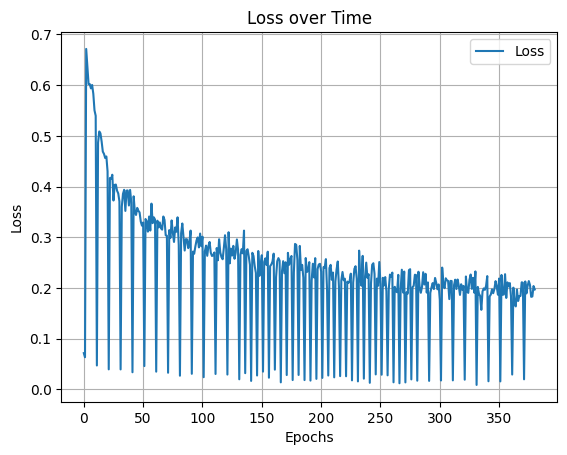

In [25]:


# Create a plot

plt.plot(lossi, label='Loss')
plt.xlabel('Epochs')  # X-axis label, e.g., number of epochs
plt.ylabel('Loss')    # Y-axis label
plt.title('Loss over Time')  # Title of the plot
plt.legend()  # Show legend
plt.grid(True)  # Optional: Add grid for better readability
plt.show()  # Display the plot

In [24]:
for i in range(10):
  train_model(model,X_train,Y_train,32,100)

  model_save_path = '/content/drive/My Drive/model.pth'  # Update the path as needed
  torch.save(model.state_dict(), model_save_path)

  print(f"Model saved to {model_save_path}")



iteration 0
loss: tensor(0.1738, device='cuda:0', grad_fn=<NllLossBackward0>)


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
loss: tensor(0.2213, device='cuda:0', grad_fn=<NllLossBackward0>)


iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
loss: tensor(0.2334, device='cuda:0', grad_fn=<NllLossBackward0>)


iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
loss: tensor(0.1990, device='cuda:0', grad_fn=<NllLossBackward0>)


iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
loss: tensor(0.2297, device='cuda:0', grad_fn=<NllLossBackward0>)


iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
loss: t

cuda


In [18]:
import torch

def validation_loss_with_confusion_matrix(model, x_val, y_val, batch_size, num_classes):
    model.eval()  # Switch to evaluation mode
    criterion = torch.nn.CrossEntropyLoss()  # Loss for classification

    # Creates a minibatch for validation
    def create_val_batch():
        batch_indices = torch.randint(0, x_val.size(0), (batch_size,))
        x_val_batch = x_val[batch_indices]
        y_val_batch = y_val[batch_indices]
        return x_val_batch, y_val_batch

    sum_val_loss = 0
    correct = 0
    num_batches = len(x_val) // batch_size  # Number of batches for validation
    all_preds = []  # Store all predictions
    all_targets = []  # Store all ground truth labels

    with torch.no_grad():  # Disable gradient computation
        for _ in range(num_batches):
            x_val_batch, y_val_batch = create_val_batch()
            val_output = model(x_val_batch)
            val_loss = criterion(val_output, y_val_batch)
            sum_val_loss += val_loss.item()

            # Calculate predictions and store them
            _, predicted = torch.max(val_output, 1)  # Get the predicted class (highest probability)

            correct += (predicted == y_val_batch).sum().item()  # Count correct predictions

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(y_val_batch.cpu().numpy())

    avg_val_loss = sum_val_loss / num_batches  # Average validation loss
    accuracy = correct / len(x_val)  # Accuracy for the entire validation set

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_targets, all_preds, labels=np.arange(num_classes))
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_percentage = (conf_matrix / row_sums) * 100




    print(f'Validation loss: {avg_val_loss}, Validation Accuracy: {accuracy * 100:.2f}%')

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return avg_val_loss, accuracy, conf_matrix


Validation loss: 0.2380087748169899, Validation Accuracy: 86.15%


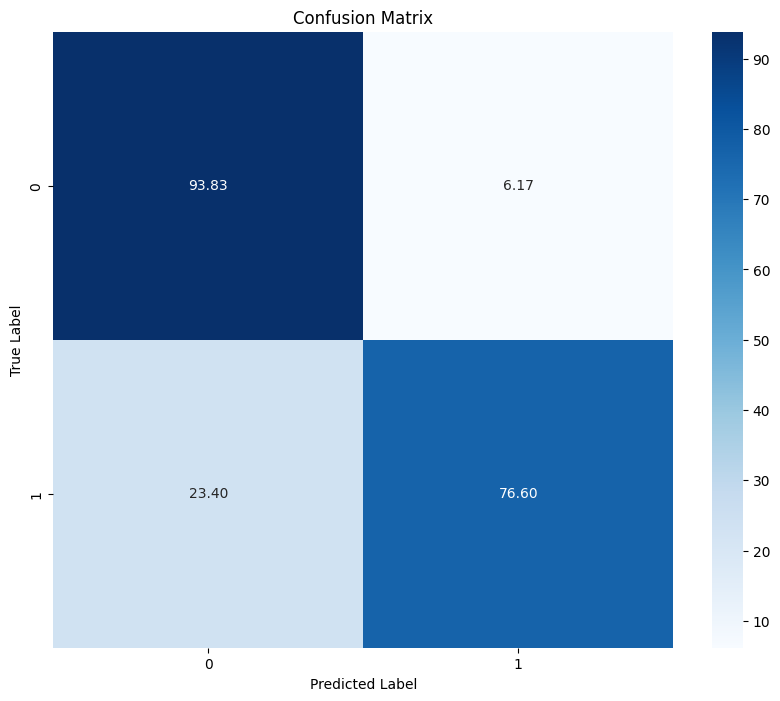

In [26]:
loss=validation_loss_with_confusion_matrix(model,X_test,Y_test,32,2)

